In [7]:
import pickle
import csv
import numpy as np
import os

In [8]:
file_exp_value = "data/pdbbind_refined_set.csv"
data_dir = "data"

In [9]:
# Read the data file and get all the pdb ids
def read_score():
    pdb_ids = []
    scores = {}
    with open(file_exp_value, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None) # Skip the header
        for row in reader:
            pdb_ids.append(row[1])
            scores[row[1]]= float(row[5])

    return pdb_ids, scores

In [13]:
# def read_data():
#     pdb_ids_file = os.path.join(data_dir, "pdb_ids.pickle")
#     features_file = os.path.join(data_dir, "features_side_2.pickle")
    
#     with open(pdb_ids_file, "rb") as f:
#         pdb_ids = pickle.load(f)
#     with open(features_file, "rb") as f:
#         features = pickle.load(f)
        
#     return pdb_ids, features

In [102]:
def _reshape(x, new_shape):
    dim_diff = np.subtract(new_shape, x.shape)
    pad_dim = np.round(dim_diff / 2).astype(int)
    x = np.pad(x, [(pad_dim[0], dim_diff[0]-pad_dim[0]),
                   (pad_dim[1], dim_diff[1]-pad_dim[1]),
                   (pad_dim[2], dim_diff[2]-pad_dim[2]),
                   (0, 0)],
               'constant')
    
    return x

In [103]:
def read_data():
    features_file = os.path.join(data_dir, "features_side_2.pickle")
    
    with open(features_file, "rb") as f:
        features = pickle.load(f)
    
    # Reshape features
    new_shape = np.array([24, 24, 24, 8])
    features_array = np.array([_reshape(f, new_shape) for f in features.values()], dtype=np.float32)
    return list(features.keys()), features_array
    #return list(features.keys()), np.array(list(features.values()), dtype=np.float32)

In [104]:
exp_ids, exp_scores = read_score()
pdb_ids, features = read_data()

In [107]:
print(len(exp_ids), len(exp_scores), len(pdb_ids), features.shape)

4154 4154 3882 (3882, 24, 24, 24, 8)


In [109]:
# Valid features (has exp values)
found_mask = [i in exp_ids for i in pdb_ids]
features = features[found_mask]
valid_pdb_ids = [i for i in pdb_ids if i in exp_ids]
exp_values = np.array([exp_scores[k] for k in valid_pdb_ids], dtype=np.float32)

In [110]:
print(features.shape, len(exp_values))

(3650, 24, 24, 24, 8) 3650


In [111]:
np.var(features.reshape((-1, 8)), axis=0)

array([0.01189438, 0.00233098, 0.00667078, 0.01281906, 0.00785731,
       0.        , 0.01961721, 0.        ], dtype=float32)

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
train_x, test_x, train_y, test_y = train_test_split(features, exp_values, test_size=0.2, random_state=1)
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1)
print(train_x.shape, test_x.shape, valid_x.shape)

(2920, 24, 24, 24, 8) (365, 24, 24, 24, 8) (365, 24, 24, 24, 8)


In [114]:
print(np.var(train_x.reshape((-1, 8)), axis=0))

[0.01184748 0.00233082 0.00666124 0.01275643 0.00787269 0.
 0.01968545 0.        ]


In [116]:
print(np.amax(train_x.reshape((-1, 8)), axis=0), np.amin(train_x.reshape((-1, 8)), axis=0))

[1. 1. 1. 1. 1. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0.]


In [117]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from tqdm import *
import glob
import os
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

/home/mhassan/anaconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [118]:
def get_model1(summary=False):
    """ Return the Keras model of the network
    """
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     input_shape=(24, 24, 24, 8),
                     padding='same',
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     bias_initializer='zeros'))
    
    model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 2nd layer group
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(Conv3D(filters=64,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 3rd layer group
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(Conv3D(filters=128,
                     kernel_size=(3, 3, 3),
                     strides = (1, 1, 1),
                     activation='relu',
                     kernel_initializer=he_uniform(seed=9876),
                     padding='same'))
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           padding='valid'))
    
    # 4th layer group
#     model.add(Conv3D(filters=128,
#                      kernel_size=(3, 3, 3),
#                      activation='relu',
#                      padding='valid'))
    
#     model.add(MaxPooling3D(pool_size=(2, 2, 2),
#                            #strides=(1, 1, 1),
#                            padding='valid'))
    
    #model.add(AveragePooling3D(pool_size=(2, 2, 2), 
    #                           padding='valid'))
                           
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(256, activation='relu'))
#     model.add(Dropout(.5))
    model.add(Dense(1, activation='linear'))
    if summary:
        print(model.summary())
    return model

In [119]:
nb_gpus = 8
nb_batch = nb_gpus*32
nb_epochs = 100
l_rate = 0.00001

In [120]:
model = get_model1()
model = multi_gpu_model(model, gpus=nb_gpus)
model.compile(optimizer=optimizers.rmsprop(lr=l_rate),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [121]:
history1 = model.fit(train_x, train_y, 
                    validation_data=(valid_x, valid_y),
                    epochs=nb_epochs,
                    batch_size=nb_batch,
                    verbose=1)

Train on 2920 samples, validate on 365 samples
Epoch 1/100
2920/2920 [==============================] - 16s 6ms/step - loss: 19.6294 - mean_squared_error: 19.6294 - val_loss: 5.8042 - val_mean_squared_error: 5.8042
Epoch 2/100
2920/2920 [==============================] - 3s 1ms/step - loss: 3.9526 - mean_squared_error: 3.9526 - val_loss: 3.3876 - val_mean_squared_error: 3.3876
Epoch 3/100
2920/2920 [==============================] - 3s 1ms/step - loss: 3.2648 - mean_squared_error: 3.2648 - val_loss: 3.3707 - val_mean_squared_error: 3.3707
Epoch 4/100
2920/2920 [==============================] - 3s 1ms/step - loss: 3.2272 - mean_squared_error: 3.2272 - val_loss: 3.3264 - val_mean_squared_error: 3.3264
Epoch 5/100
2920/2920 [==============================] - 3s 1ms/step - loss: 3.1844 - mean_squared_error: 3.1844 - val_loss: 3.5142 - val_mean_squared_error: 3.5142
Epoch 6/100
2920/2920 [==============================] - 3s 1ms/step - loss: 3.1565 - mean_squared_error: 3.1565 - val_loss: 

Epoch 50/100
2920/2920 [==============================] - 3s 957us/step - loss: 2.4754 - mean_squared_error: 2.4754 - val_loss: 3.1846 - val_mean_squared_error: 3.1846
Epoch 51/100
2920/2920 [==============================] - 3s 1ms/step - loss: 2.5284 - mean_squared_error: 2.5284 - val_loss: 2.9110 - val_mean_squared_error: 2.9110
Epoch 52/100
2920/2920 [==============================] - 3s 966us/step - loss: 2.4947 - mean_squared_error: 2.4947 - val_loss: 2.9024 - val_mean_squared_error: 2.9024
Epoch 53/100
2920/2920 [==============================] - 3s 1ms/step - loss: 2.4440 - mean_squared_error: 2.4440 - val_loss: 2.8999 - val_mean_squared_error: 2.8999
Epoch 54/100
2920/2920 [==============================] - 3s 973us/step - loss: 2.4218 - mean_squared_error: 2.4218 - val_loss: 2.9036 - val_mean_squared_error: 2.9036
Epoch 55/100
2920/2920 [==============================] - 3s 1ms/step - loss: 2.4431 - mean_squared_error: 2.4431 - val_loss: 2.9723 - val_mean_squared_error: 2.972

2920/2920 [==============================] - 3s 1ms/step - loss: 2.0450 - mean_squared_error: 2.0450 - val_loss: 3.0485 - val_mean_squared_error: 3.0485
Epoch 100/100
2920/2920 [==============================] - 4s 1ms/step - loss: 2.0531 - mean_squared_error: 2.0531 - val_loss: 2.7946 - val_mean_squared_error: 2.7946


In [55]:
history = model.fit(train_x, train_y, 
                    validation_data=(valid_x, valid_y),
                    epochs=nb_epochs,
                    batch_size=nb_batch,
                    verbose=1)

Train on 2920 samples, validate on 365 samples
Epoch 1/100
2920/2920 [==============================] - 14s 5ms/step - loss: 34.9488 - mean_squared_error: 34.9488 - val_loss: 24.3936 - val_mean_squared_error: 24.3936
Epoch 2/100
2920/2920 [==============================] - 3s 947us/step - loss: 14.7472 - mean_squared_error: 14.7472 - val_loss: 7.1446 - val_mean_squared_error: 7.1446
Epoch 3/100
2920/2920 [==============================] - 3s 951us/step - loss: 4.3024 - mean_squared_error: 4.3024 - val_loss: 4.0991 - val_mean_squared_error: 4.0991
Epoch 4/100
2920/2920 [==============================] - 3s 952us/step - loss: 3.5207 - mean_squared_error: 3.5207 - val_loss: 4.0628 - val_mean_squared_error: 4.0628
Epoch 5/100
2920/2920 [==============================] - 3s 951us/step - loss: 3.4902 - mean_squared_error: 3.4902 - val_loss: 4.0489 - val_mean_squared_error: 4.0489
Epoch 6/100
2920/2920 [==============================] - 3s 969us/step - loss: 3.4863 - mean_squared_error: 3.486

Epoch 98/100
2920/2920 [==============================] - 3s 936us/step - loss: 2.3178 - mean_squared_error: 2.3178 - val_loss: 3.5561 - val_mean_squared_error: 3.5561
Epoch 99/100
2920/2920 [==============================] - 3s 981us/step - loss: 2.4404 - mean_squared_error: 2.4404 - val_loss: 3.0321 - val_mean_squared_error: 3.0321
Epoch 100/100
2920/2920 [==============================] - 3s 941us/step - loss: 2.2996 - mean_squared_error: 2.2996 - val_loss: 3.7183 - val_mean_squared_error: 3.7183


In [122]:
history1.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

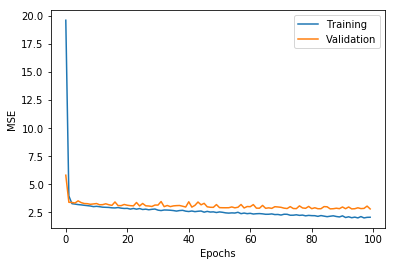

In [123]:
plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(["Training", "Validation"])
plt.show()

In [124]:
train_r2 = r2_score(y_pred=model.predict(train_x), y_true=train_y)
test_r2 = r2_score(y_pred=model.predict(test_x), y_true=test_y)
valid_r2 = r2_score(y_pred=model.predict(valid_x), y_true=valid_y)
print("Train R2: %0.3f , Test R2: %0.3f, Valid R2: %0.3f" % (train_r2, test_r2, valid_r2))

Train R2: 0.511 , Test R2: 0.221, Valid R2: 0.306
